In [1]:
import jax
import jax.numpy as jnp

from jax import random
from jax import grad,value_and_grad
from jax.test_util import check_grads

# Jacobian vs Grad

Grad works on scalar functions, Jacobian works on vector functions.

In [2]:
# f(x) = x1^2 + x2^2
# paraboloid in 3D space
def paraboloid(x):
    return jnp.sum(x**2)

# gradf(x) = [2x1, 2x2]
# Our explicit gradient function
def g_paraboloid(x):
    return 2 * x 

# JAX's grad operator
grad_paraboloid = grad(paraboloid)

# three different input
input = jnp.array([[0.2, 0.3], [2.4, 3.6], [4.4, 2.1]])
for x in input:
    print("Explicit Gradient Function: ", g_paraboloid(x))
    print("JAX Gradient Function: ", grad_paraboloid(x))
    print("")

Explicit Gradient Function:  [0.4 0.6]
JAX Gradient Function:  [0.4 0.6]

Explicit Gradient Function:  [4.8 7.2]
JAX Gradient Function:  [4.8 7.2]

Explicit Gradient Function:  [8.8 4.2]
JAX Gradient Function:  [8.8 4.2]



In [3]:
jax.jacfwd(paraboloid)(input)

Array([[0.4, 0.6],
       [4.8, 7.2],
       [8.8, 4.2]], dtype=float32)

In [4]:
#Need to use the jax.jacfwd operator to compute the gradient of a vector valued function
#grad will throw an error
#vector valiued function
def f(x):
    return jnp.array([x[0]**2, x[1]**2])

#gradf(x) = [2x1, 2x2]
def g_f(x):
    return jnp.array([2*x[0], 2*x[1]])

#JAX's grad operator
grad_f = jax.jacfwd(f)

#three different input
input = jnp.array([0.2, 0.3])
print("Explicit Gradient Function: ", g_f(input))
print("JAX Gradient Function: ", grad_f(input))
print("")


Explicit Gradient Function:  [0.4 0.6]
JAX Gradient Function:  [[0.4 0. ]
 [0.  0.6]]



# Bilevel Optimizarion

We will optimize min_x F(x,y*)

with y* = argmin_y f(x,y)

The optimal solution is y* = x, which yeilds x,y = (1.5, 1.5)

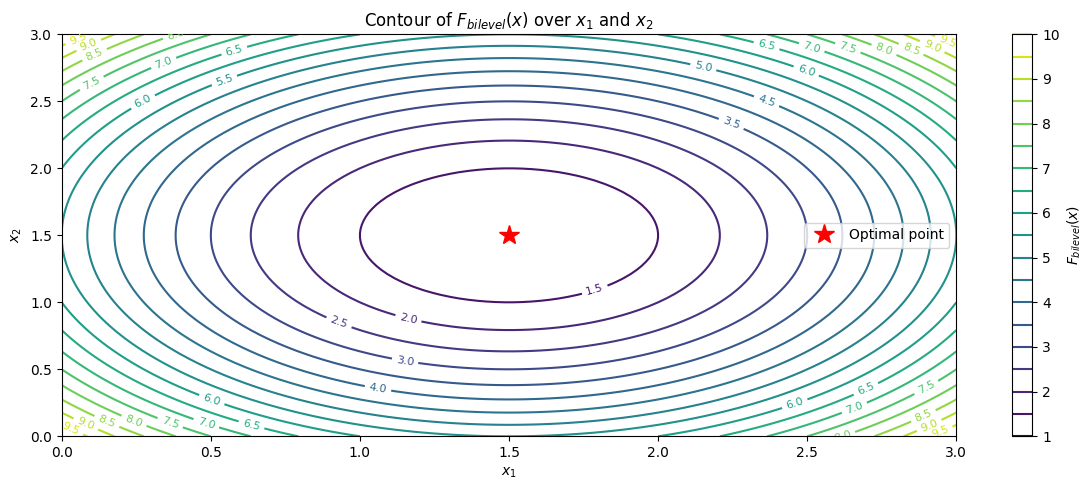

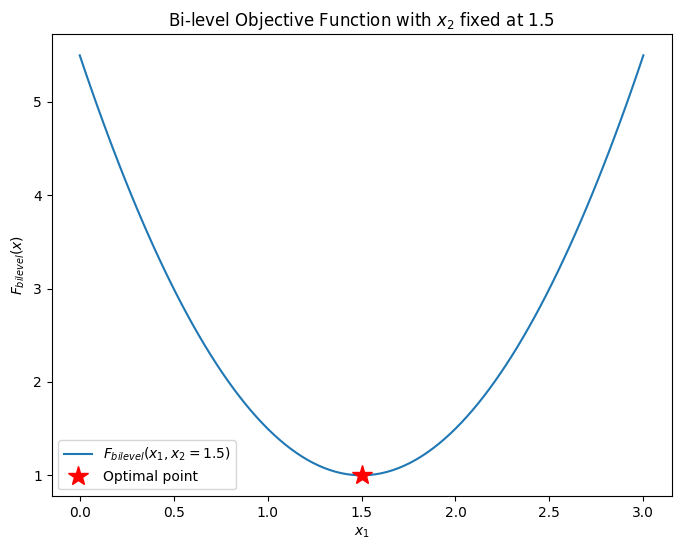

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Upper-level objective function
def F(x, y):
    # x and y are vectors in ℝ²
    return np.sum((x - np.array([1, 1]))**2) + np.sum((y - np.array([2, 2]))**2)

# Lower-level objective function
def f(x, y):
    # x and y are vectors in ℝ²
    return np.sum((y - x)**2)

# Lower-level solution: y* minimizes f(x, y) for a given x
def y_star(x):
    return x  # The optimal y for any given x is x

# Upper-level objective, accounting for the lower-level solution
def F_bilevel(x):
    y = y_star(x)
    return F(x, y)

# Correct analytical solution
x_opt = np.array([1.5, 1.5])
y_opt = y_star(x_opt)

# Create a grid over x1 and x2
x1 = np.linspace(0, 3, 100)
x2 = np.linspace(0, 3, 100)
X1, X2 = np.meshgrid(x1, x2)

# Evaluate F_bilevel over the grid
F_bi = (X1 - 1)**2 + (X1 - 2)**2 + (X2 - 1)**2 + (X2 - 2)**2

# Plotting
plt.figure(figsize=(12, 5))

# Contour plot of the bi-level objective F_bilevel(x)
plt.subplot(1, 1, 1)
contour = plt.contour(X1, X2, F_bi, levels=20)
plt.clabel(contour, inline=True, fontsize=8)
plt.plot(x_opt[0], x_opt[1], 'r*', markersize=15, label='Optimal point')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Contour of $F_{bilevel}(x)$ over $x_1$ and $x_2$')
plt.legend()
plt.colorbar(contour, label='$F_{bilevel}(x)$')

plt.tight_layout()
plt.show()

# Fix x2 = 1.5 and vary x1
x1 = np.linspace(0, 3, 100)
x2_fixed = 1.5
F_bi_fixed = (x1 - 1)**2 + (x1 - 2)**2 + (x2_fixed - 1)**2 + (x2_fixed - 2)**2

plt.figure(figsize=(8, 6))
plt.plot(x1, F_bi_fixed, label=f'$F_{{bilevel}}(x_1, x_2={x2_fixed})$')
plt.plot(x_opt[0], F_bilevel(x_opt), 'r*', markersize=15, label='Optimal point')
plt.xlabel('$x_1$')
plt.ylabel('$F_{bilevel}(x)$')
plt.title('Bi-level Objective Function with $x_2$ fixed at 1.5')
plt.legend()
plt.show()



In [11]:
for _ in range(100):
    x = x - 0.01 * grad(F_bilevel)(x)
x, F_bilevel(x)

(Array(1.4996412, dtype=float32, weak_type=True),
 Array(1.0000005, dtype=float32))

## Total derivative

I manually solve the derivative calulations to find compute the total derivative. Note that you do not have to nest. You compute the derivative for the y optimization, then the total for x

In [16]:
def F(x, y):
    return np.sum((x - 1)**2) + np.sum((y - 2)**2)

def f(x, y):
    return np.sum((x - y)**2)

def df_dy(x, y):
    return 2 * (y - x)

def d2f_dy2(x, y):
    return 2 * np.ones_like(y)

def dF_dx(x, y):
    return 2 * (x - 1)

def dF_dy(x, y):
    return 2 * (y - 2)

def dy_dx(x, y):
    # For f(x, y) = (x - y)^2, the optimal y is x, so dy/dx = 1
    return np.ones_like(x)


In [22]:
def naive_gradient(x, y, learning_rate=0.01, num_iterations=500):
    x = x.copy()
    y = y.copy()
    x_history = [x.copy()]
    y_history = [y.copy()]
    
    for _ in range(num_iterations):
        # Update y to minimize f(x, y)
        for _ in range(10):
            y -= learning_rate * df_dy(x, y)
        
        y_history.append(y.copy())
        
        implicit_grad = dF_dx(x, y)
        x -= learning_rate * implicit_grad
        x_history.append(x.copy())
    
    return x_history, y_history

np.random.seed(0)  # For reproducibility
x_initial = np.random.randn(10)
y_initial = np.random.randn(10)

x_naive, y_naive = naive_gradient(x_initial, y_initial)

x_naive[-1], y_naive[-1]

(array([1.00003134, 0.99997539, 0.99999913, 1.00005091, 1.00003559,
        0.99991888, 0.99999795, 0.99995277, 0.99995474, 0.99997582]),
 array([1.00003519, 0.99997237, 0.99999902, 1.00005716, 1.00003996,
        0.99990893, 0.9999977 , 0.99994697, 0.99994919, 0.99997285]))

In [23]:
def cosine_similarity(array1, array2):
    """
    Compute the cosine similarity between two JAX arrays.

    Args:
        array1 (jax.numpy.ndarray): First array.
        array2 (jax.numpy.ndarray): Second array.

    Returns:
        float: Cosine similarity between array1 and array2.
    """
    # Compute the inner product of the two arrays
    inner_product = jnp.vdot(array1, array2)
    # Compute the L2 norms (Euclidean norms) of each array
    norm1 = jnp.linalg.norm(array1)
    norm2 = jnp.linalg.norm(array2)
    # Calculate cosine similarity
    cosine_sim = inner_product / (norm1 * norm2)
    return cosine_sim

Iteration 0, Direct Gradient: [ 1.52810469 -1.19968558 -0.04252403  2.4817864   1.73511598 -3.95455576
 -0.09982316 -2.30271442 -2.2064377  -1.178803  ], Product: [-3.11922554 -1.47710606 -2.39827796 -2.9813247  -2.59140856 -3.81226896
 -1.21086322 -4.39063318 -3.52616486 -5.24549754], Cosine Similarity: 0.3709
Iteration 1, Direct Gradient: [ 1.55992711 -1.14614975  0.00629201  2.49177716  1.75224183 -3.79921927
 -0.07360944 -2.16884746 -2.09178565 -1.05031699], Product: [-2.62913567 -1.78241954 -2.32427111 -2.34599992 -2.16269117 -4.1757362
 -1.36868296 -4.35006254 -3.62963228 -4.84393933], Cosine Similarity: 0.4286
Iteration 2, Direct Gradient: [ 1.58131128 -1.08757836  0.05265159  2.48886162  1.76045082 -3.63972016
 -0.04476359 -2.03846926 -1.97735729 -0.93243186], Product: [-2.22478481 -2.02116858 -2.2553217  -1.82742666 -1.81089621 -4.44353868
 -1.4923565  -4.29306366 -3.69324064 -4.49427263], Cosine Similarity: 0.4726
Iteration 3, Direct Gradient: [ 1.59418075 -1.02540343  0.0967

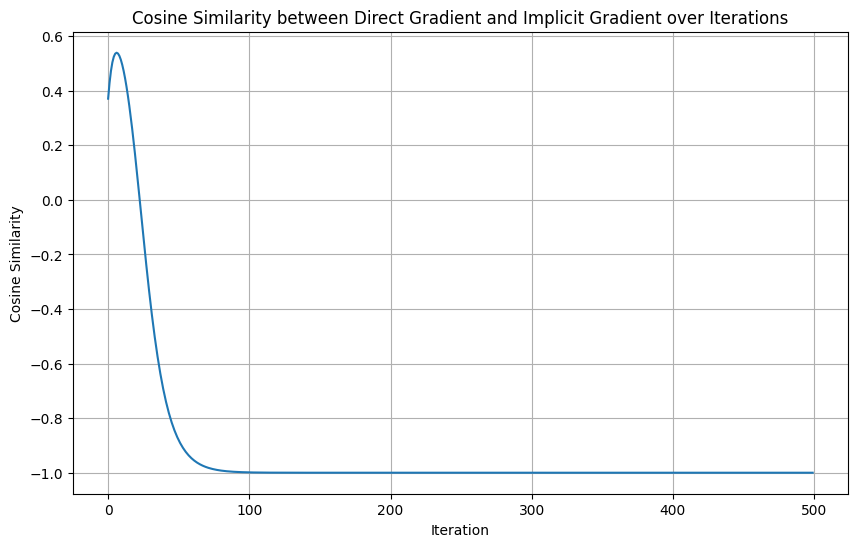

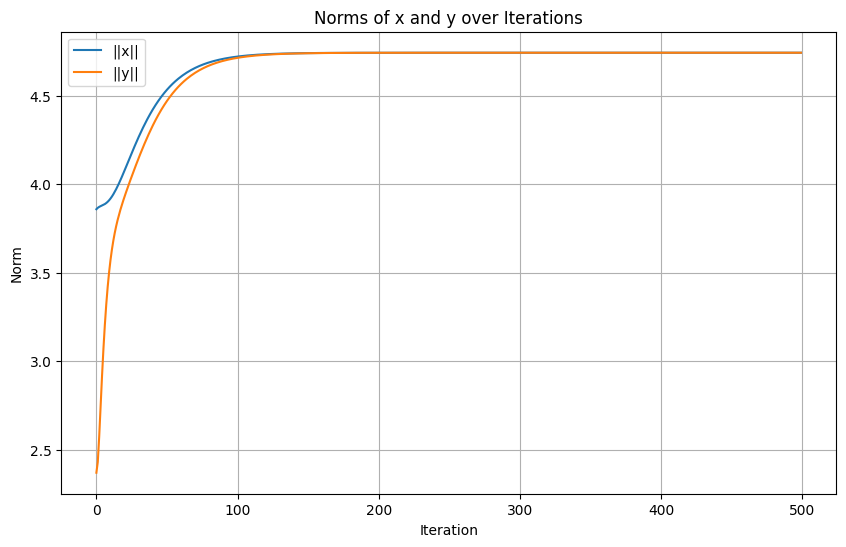

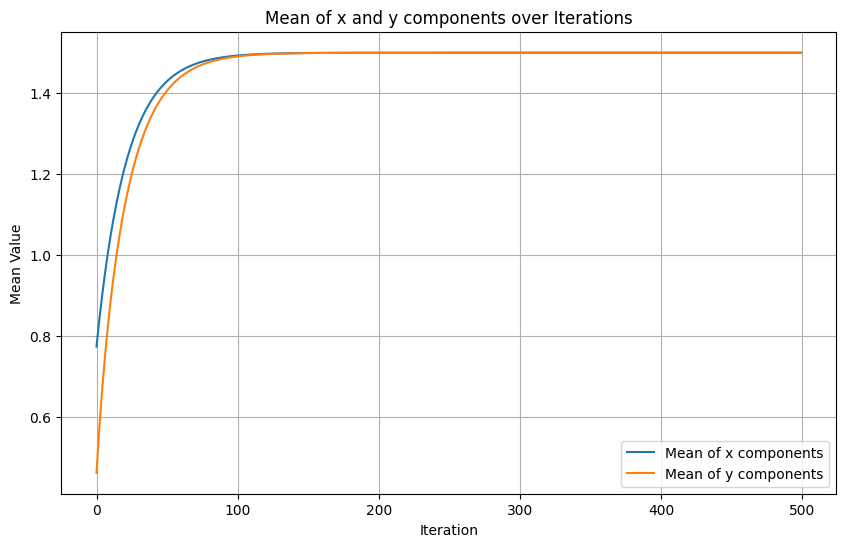

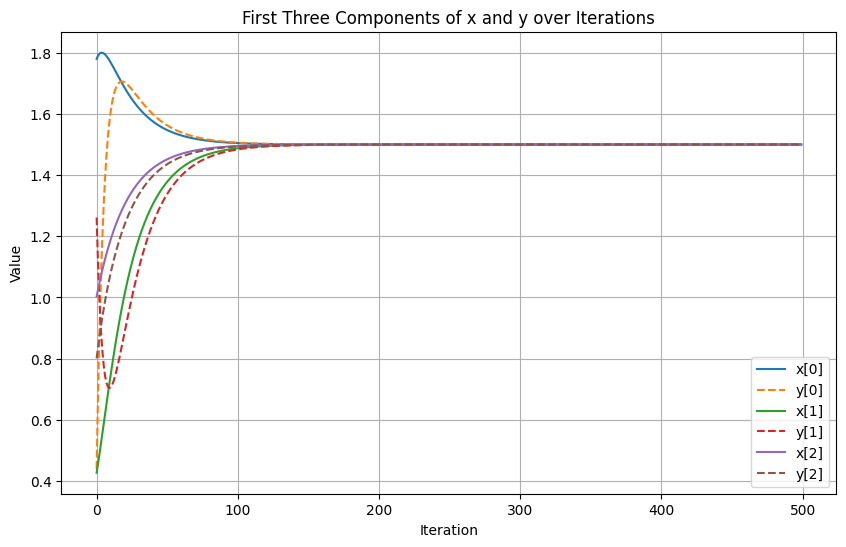

In [30]:
def total_gradient(x, y, learning_rate=0.01, num_iterations=500):
    x = x.copy()
    y = y.copy()
    x_history = []
    y_history = []
    cos_sim_list = []
    
    innerloops = 10
    for i in range(num_iterations):
        for _ in range(innerloops):
            y -= learning_rate * df_dy(x, y)
        y_history.append(y.copy())

        direct_gradient = dF_dx(x, y)
        product = dF_dy(x, y) * dy_dx(x, y)
        implicit_grad = direct_gradient + product  
        cos_sim = cosine_similarity(direct_gradient, product)
        cos_sim_list.append(cos_sim)

        print(f"Iteration {i}, Direct Gradient: {direct_gradient}, Product: {product}, Cosine Similarity: {cos_sim:.4f}")

        x -= learning_rate * implicit_grad
        x_history.append(x.copy())
    
    return x_history, y_history, cos_sim_list

x_total, y_total, cos_similarities = total_gradient(x_initial, y_initial)

# Convert history lists to arrays
x_total = np.array(x_total)
y_total = np.array(y_total)
iterations = np.arange(len(cos_similarities))

# Plotting cosine similarities over iterations
plt.figure(figsize=(10,6))
plt.plot(iterations, cos_similarities)
plt.xlabel('Iteration')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Direct Gradient and Implicit Gradient over Iterations')
plt.grid(True)
plt.show()

# Plotting the norms of x and y over iterations
x_norms = np.linalg.norm(x_total, axis=1)
y_norms = np.linalg.norm(y_total, axis=1)

plt.figure(figsize=(10,6))
plt.plot(iterations, x_norms, label='||x||')
plt.plot(iterations, y_norms, label='||y||')
plt.xlabel('Iteration')
plt.ylabel('Norm')
plt.title('Norms of x and y over Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the mean of x and y components over iterations
x_means = x_total.mean(axis=1)
y_means = y_total.mean(axis=1)

plt.figure(figsize=(10,6))
plt.plot(iterations, x_means, label='Mean of x components')
plt.plot(iterations, y_means, label='Mean of y components')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.title('Mean of x and y components over Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the first three components of x and y over iterations
plt.figure(figsize=(10,6))

for i in range(3):
    plt.plot(iterations, x_total[:, i], label=f'x[{i}]')
    plt.plot(iterations, y_total[:, i], label=f'y[{i}]', linestyle='--')

plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('First Three Components of x and y over Iterations')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
x_analytical = 1.5
y_analytical = 1.5

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(x_total, label='total x')
plt.plot(y_total, label='total y')
plt.plot(x_naive, label='naive x')
plt.plot(y_naive, label='naive y')
plt.axhline(y=x_analytical, color='r', linestyle='--', label='Analytical solution')
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title('Bi-level Optimization: Comparison of Methods')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final results:")
print(f"Unrolled: x = {x_total[-1]:.4f}, y = {y_total[-1]:.4f}")
print(f"Analytical: x = {x_analytical:.4f}, y = {y_analytical:.4f}")

In [ ]:
#learn y_star(x) dynamically using envelope theorem

def F(x, y):
    return (x - 1)**2 + (y - 2)**2

def f(x, y):
    return (y - x)**2  # Lower-level objective

def learn_y_star(x, y_init=0.1, num_y_iterations=20, learning_rate_y=0.1):
    y = y_init
    for _ in range(num_y_iterations):
        y -= learning_rate_y * df_dy(x, y)  # Gradient descent on the lower-level objective f(x, y)
    return y

# Upper-level objective using learned y_star(x)
def F_bilevel(x):
    y_star = learn_y_star(x)  # Learn y_star dynamically
    return F(x, y_star)  # Plug y_star into F

def optimize_x(num_iterations, learning_rate_x):
    x = 0.1  # Initial value of x
    x_history = [x]
    
    for _ in range(num_iterations):
        # Compute the gradient of the upper-level objective
        grad_x = grad(F_bilevel)(x)  # Gradient with respect to x, which includes y_star(x)
        
        # Update x using gradient descent
        x -= learning_rate_x * grad_x
        x_history.append(x)
    
    return x_history

# Run the optimization
x_history = optimize_x(num_iterations=100, learning_rate_x=0.05)
x_history[-1], learn_y_star(x_history[-1])  # y_star at the optimal x


# WIP after this block

In [ ]:
import numpy as np

# Define outer and inner level functions
def F(x, y):
    """Outer-level objective."""
    return (x - 1)**2 + (y - 2)**2

def g(x, y):
    """Inner-level objective."""
    return (y - x)**2

# Smoothed version of the inner minimization problem
def g_star(x, alpha, num_iterations=10):
    """Solve the inner problem for a fixed x via gradient descent."""
    y = 0.1
    for _ in range(num_iterations):
        grad_y = 2 * (y - x) + alpha * y  # Gradient of smoothed inner function
        y -= 0.01 * grad_y  # Gradient descent update for y
    return y

# Define the Lagrangian
def Lagrangian(x,y, lambda_, alpha):
    """Lagrangian function combining primal and dual variables."""
    # Constraint function h(z)
    return F(x,y) + lambda_ * h_tilde(x)

# Gradient of the Lagrangian w.r.t z (x, y) using autograd
def grad_Lagrangian_wrt_z(x,y, lambda_, alpha):
    """Compute the gradient of the Lagrangian w.r.t z (which includes both x and y)."""
    return grad(Lagrangian, argnums=(0,1))(x,y, lambda_, alpha)

def h_tilde(x,y):
    return g(x, y) - g_star(x, 0.1, num_iterations=20)
    

# Primal-dual optimizer
def primal_dual_bilevel_optimizer(num_iterations, learning_rate, alpha, init_x, init_y):
    """Primal-dual optimization for bilevel problems."""
    x, y = init_x, init_y
    lambda_ = 1.0  # Initial value of the dual variable
    
    x_history = [x]
    y_history = [y]
    lambda_history = [lambda_]


    for t in range(num_iterations):
        # Step 1: Update y (inner variable) using gradient descent (implicit step)
        y_history.append(y)
        
        
        lambda_ = max(0, lambda_ + learning_rate * h_tilde(x,y))  # Ensure non-negative lambda
        lambda_history.append(lambda_)
        
        # Step 3: Update the primal variable z = (x, y) using the gradient of the Lagrangian
        grad_x,grad_y = grad_Lagrangian_wrt_z(x,y, lambda_, alpha)
        x -= learning_rate * grad_x
        y -= learning_rate *grad_y # Update z = (x, y)
        x_history.append(x)
    
    return x_history, y_history, lambda_history

# Running the primal-dual optimizer
x_history, y_history, lambda_history = primal_dual_bilevel_optimizer(
    num_iterations=100, learning_rate=0.01, alpha=0.1, init_x=0.5, init_y=0.5
)

# Final optimized values
print("Final x:", x_history[-1])
print("Final y:", y_history[-1])
print("Final lambda:", lambda_history[-1])


## Unrolling gradients

This is a nested algorithm. 

First, in the inner loop calculate df/dy for a given x. 

Then in the outer loop, use all the iterates from the inner to get dF/dy

Then calculate dF/dx as usual. 

We now have an expression for DF = dF/dx + dF/dy*dy/dx

In [ ]:
import jax
import jax.numpy as jnp

def F(x, y):
    return (x - 1)**2 + (y - 2)**2

def f(x, y):
    return (x - y)**2

grad_f_y = jax.grad(f, argnums=1)
grad_F_x = jax.grad(F, argnums=0)
grad_F_y = jax.grad(F, argnums=1)

def unrolled_gradient_with_jacobian(x_init, y_init, inner_lr=0.1, outer_lr=0.01, inner_steps=20, outer_steps=50):
    def inner_loop_single(x, y_init):
        def body_fun(y, _):
            y_next = y - inner_lr * grad_f_y(x, y) #df/dy
            return y_next, y_next
        _, y_history = jax.lax.scan(body_fun, y_init, None, length=inner_steps)
        return jnp.concatenate([jnp.array([y_init]), y_history])

    def total_loss(x, y_history):
        return jnp.sum(jax.vmap(lambda y: F(x, y))(y_history))

    x = x_init
    x_history = [x]
    y_histories = []

    for _ in range(outer_steps):
        # Compute y_history
        y_history = inner_loop_single(x, y_init)
        y_histories.append(y_history)

        # Compute Jacobian of y_history with respect to x
        J_y_x = jax.jacfwd(inner_loop_single, argnums=0)(x, y_init) #dx/dy

        # Compute gradients
        dF_dx = jax.grad(lambda x: total_loss(x, y_history))(x)
        dF_dy = jax.vmap(grad_F_y, in_axes=(None, 0))(x, y_history)

        # Compute total gradient
        #total_grad = dF/dx + ∑_t (dF/dy_t * dy_t/dx)

        total_grad = dF_dx + jnp.sum(dF_dy * J_y_x) #dF/dx + dF/dy * dx/dy

        # Update x
        x = x - outer_lr * total_grad
        x_history.append(x)

    return jnp.array(x_history), jnp.array(y_histories)

# Run optimization
x_unrolled, y_unrolled = unrolled_gradient_with_jacobian(0.1, 0.1)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(x_unrolled)
plt.title('x trajectory (Unrolled with Jacobian)')
plt.xlabel('Iteration')
plt.ylabel('x value')

plt.plot([yh[-1] for yh in y_unrolled])
plt.title('Final y values (Unrolled with Jacobian)')
plt.xlabel('Outer Iteration')
plt.ylabel('y value')
plt.axhline(y=x_analytical, color='r', linestyle='--', label='Analytical solution')

plt.tight_layout()
plt.show()

print(f"Final x value: {x_unrolled[-1]}")
print(f"Final y value: {y_unrolled[-1][-1]}")
print(f"Final objective value: {F(x_unrolled[-1], y_unrolled[-1][-1])}")

## Implicit function theorem

Use IFT to get the total derivative. Note that this doesn't require nesting either

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Define the functions using jax.numpy
def F(x, y):
    return jnp.sum((x - 1)**2) + jnp.sum((y - 2)**2)

def f(x, y):
    return jnp.sum((x - y)**2)

# Compute gradients using JAX's automatic differentiation
df_dy = jax.grad(f, argnums=1)
dF_dx = jax.grad(F, argnums=0)
dF_dy = jax.grad(F, argnums=1)

# Compute second-order derivatives (Hessians)
def d2f_dy2(x, y):
    return jax.hessian(f, argnums=1)(x, y)

def d2f_dxdy(x, y):
    return jax.jacobian(jax.grad(f, argnums=1), argnums=0)(x, y)

# Cosine similarity function
def cosine_similarity(a, b):
    a_flat = a.flatten()
    b_flat = b.flatten()
    dot_product = jnp.dot(a_flat, b_flat)
    norm_a = jnp.linalg.norm(a_flat)
    norm_b = jnp.linalg.norm(b_flat)
    cosine_sim = dot_product / (norm_a * norm_b + 1e-8)  # Add epsilon to avoid division by zero
    return cosine_sim

def total_gradient(x_init, y_init, learning_rate=0.01, num_iterations=500):
    x = x_init
    y = y_init
    x_history, y_history = [x], [y]
    cos_sim_list = []

    for i in range(num_iterations):
        # Inner optimization step (lower-level problem)
        y = y - learning_rate * df_dy(x, y)
        y_history.append(y)

        # Compute implicit gradient using the Implicit Function Theorem (IFT)
        # dy_dx = - (d²f/dxdy) / (d²f/dy²)
        H_yy = d2f_dy2(x, y)  # Hessian w.r.t y
        H_xy = d2f_dxdy(x, y)  # Cross-derivative w.r.t x and y

        # Inverse of H_yy
        H_yy_inv = jnp.linalg.inv(H_yy)

        # Compute dy_dx
        dy_dx = -jnp.matmul(H_yy_inv, H_xy)

        # Compute direct gradient and implicit component
        direct_gradient = dF_dx(x, y)
        implicit_component = jnp.matmul(dF_dy(x, y), dy_dx)

        # Total gradient
        total_grad = direct_gradient + implicit_component

        # Compute cosine similarity between direct_gradient and implicit_component
        cos_sim = cosine_similarity(direct_gradient, implicit_component)
        cos_sim_list.append(cos_sim)

        # Outer optimization step (upper-level problem)
        x = x - learning_rate * total_grad
        x_history.append(x)

    return jnp.array(x_history), jnp.array(y_history), jnp.array(cos_sim_list)

# Initialize x and y as jnp arrays (e.g., in ℝ^2 for simplicity)
x_init = jnp.array([0.1, 0.1])
y_init = jnp.array([0.1, 0.1])

# Run optimization
x_total, y_total, cos_similarities = total_gradient(x_init, y_init)

# Plot results
plt.figure(figsize=(12, 5))

# Plot x trajectory
plt.subplot(1, 2, 1)
for i in range(x_init.shape[0]):
    plt.plot(x_total[:, i], label=f'x[{i}]')
plt.title('x trajectory')
plt.xlabel('Iteration')
plt.ylabel('x value')
plt.legend()

# Plot y trajectory
plt.subplot(1, 2, 2)
for i in range(y_init.shape[0]):
    plt.plot(y_total[:, i], label=f'y[{i}]')
plt.title('y trajectory')
plt.xlabel('Iteration')
plt.ylabel('y value')
plt.legend()

plt.tight_layout()
plt.show()

# Plot cosine similarities over iterations
plt.figure(figsize=(8, 6))
plt.plot(cos_similarities)
plt.xlabel('Iteration')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Direct Gradient and Implicit Component')
plt.grid(True)
plt.show()

print(f"Final x value: {x_total[-1]}")
print(f"Final y value: {y_total[-1]}")
print(f"Final objective value: {F(x_total[-1], y_total[-1])}")


# Solving a matrix game with IFT
https://www.cs.cmu.edu/~conitzer/stackelbergSYNTHESE.pdf

In [32]:
import jax
import jax.numpy as jnp
from jax import grad, jit, jacfwd
import optax
import matplotlib.pyplot as plt

# Set random seed
key = jax.random.PRNGKey(32)

# Combined payoff matrix
payoffs = jnp.array([
    [[1., 1.], [3., 0.]],
    [[0., 0.], [2., 1.]]
])

def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def expected_utility(x, y):
    p1 = sigmoid(x)
    p2 = sigmoid(y)
    probs = jnp.array([[p1*p2, p1*(1-p2)], [(1-p1)*p2, (1-p1)*(1-p2)]])
    u1 = jnp.sum(probs * payoffs[:,:,0])
    u2 = jnp.sum(probs * payoffs[:,:,1])
    return p1, p2, u1, u2

@jit
def stackelberg_gradient(x, y):
    grad_u2_y = grad(lambda y: expected_utility(x, y)[3])(y)
    hessian_u2_y = jacfwd(grad(lambda y: expected_utility(x, y)[3]))(y)
    grad_u2_y_x = jacfwd(lambda x: grad(lambda y: expected_utility(x, y)[3])(y))(x)
    grad_y_star = -grad_u2_y_x / hessian_u2_y
    grad_u1_x = grad(lambda x: expected_utility(x, y)[2])(x)
    grad_u1_y = grad(lambda y: expected_utility(x, y)[2])(y)
    return grad_u1_x + grad_y_star * grad_u1_y

@jit
def update(x, y, opt_state1, opt_state2):
    # Update follower (player 2)
    grad_u2 = grad(lambda y: -expected_utility(x, y)[3])(y)
    updates2, opt_state2 = optimizer2.update(grad_u2, opt_state2)
    y = optax.apply_updates(y, updates2)
    
    # Update leader (player 1)
    grad_stackelberg = stackelberg_gradient(x, y)
    updates1, opt_state1 = optimizer1.update(grad_stackelberg, opt_state1)
    x = optax.apply_updates(x, updates1)
    
    return x, y, opt_state1, opt_state2

def plot_strategies(p1, p2, iterations, seed, follower_lr, leader_lr, reg):
    plt.figure(figsize=(10, 6))
    plt.plot(p1, color='blue', label='row - p(up)')
    plt.plot(p2, color='orange', label='col - p(left)') 
    plt.ylabel('Probability')
    plt.xlabel('Step')
    plt.legend()
    plt.title(f'# of Iterations: {iterations}, Seed: {seed}, Follower lr {follower_lr}, Leader lr {leader_lr})')
    #plt.savefig(f'jax_stackelberg_{iterations}_seed={seed}_flr={follower_lr}_llr={leader_lr}_reg={reg}.png')
    plt.close()

# Hyperparameters
outer_iterations = 200
inner_iterations = 5
follower_lr = 0.05
leader_lr = 0.01
regularization = False
weight_decay = 0.1 if regularization else 0.0

# Initialize strategies
x = jax.random.uniform(key, shape=())
y = jax.random.uniform(key, shape=())

print(f"Player 1 initial strategy (probability of playing Up): {sigmoid(x):.4f}")
print(f"Player 2 initial strategy (probability of playing Left): {sigmoid(y):.4f}")

# Set up optimizers
optimizer1 = optax.adam(learning_rate=leader_lr)
optimizer2 = optax.adam(learning_rate=follower_lr)
opt_state1 = optimizer1.init(x)
opt_state2 = optimizer2.init(y)

p1_strategies = []
p2_strategies = []

for _ in range(outer_iterations):
    grad_u2 = grad(lambda y: -expected_utility(x, y)[3])(y)
    updates2, opt_state2 = optimizer2.update(grad_u2, opt_state2)
    y = optax.apply_updates(y, updates2)
    
    x, y, opt_state1, opt_state2 = update(x, y, opt_state1, opt_state2)
    p_up, p_left, _, _ = expected_utility(x, y)
    p1_strategies.append(p_up)
    p2_strategies.append(p_left)

# Final strategies and utilities
p1_strategy = sigmoid(x)
p2_strategy = sigmoid(y)
_, _, final_u1, final_u2 = expected_utility(x, y)

print(f"Player 1 strategy (probability of playing Up): {p1_strategy:.4f}")
print(f"Player 2 strategy (probability of playing Left): {p2_strategy:.4f}")
print(f"Player 1 expected utility: {final_u1:.4f}")
print(f"Player 2 expected utility: {final_u2:.4f}")

# Compute and print gradients
stackelberg_grad = stackelberg_gradient(x, y)
print(f"Stackelberg gradient for Player 1's strategy: {stackelberg_grad:.4f}")

grad_u2 = grad(lambda y: expected_utility(x, y)[3])(y)
print(f"Gradient for Player 2's strategy: {grad_u2:.4f}")

plot_strategies(p1_strategies, p2_strategies, outer_iterations, 32, follower_lr, leader_lr, regularization)

Player 1 initial strategy (probability of playing Up): 0.6796
Player 2 initial strategy (probability of playing Left): 0.6796
Player 1 strategy (probability of playing Up): 0.5129
Player 2 strategy (probability of playing Left): 0.9934
Player 1 expected utility: 0.5262
Player 2 expected utility: 0.5127
Stackelberg gradient for Player 1's strategy: -0.0086
Gradient for Player 2's strategy: 0.0002


In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, jacfwd
import matplotlib.pyplot as plt

# Set random seed
key = jax.random.PRNGKey(32)

# Combined payoff matrix
payoffs = jnp.array([
    [[1., 1.], [3., 0.]],
    [[0., 0.], [2., 1.]]
])

def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def expected_utility(x, y):
    p1 = sigmoid(x)
    p2 = sigmoid(y)
    probs = jnp.array([[p1*p2, p1*(1-p2)], [(1-p1)*p2, (1-p1)*(1-p2)]])
    u1 = jnp.sum(probs * payoffs[:,:,0])
    u2 = jnp.sum(probs * payoffs[:,:,1])
    return p1, p2, u1, u2

@jit
def stackelberg_gradient(x, y):
    grad_u2_y = grad(lambda y: expected_utility(x, y)[3])(y)
    hessian_u2_y = jacfwd(grad(lambda y: expected_utility(x, y)[3]))(y)
    grad_u2_y_x = jacfwd(lambda x: grad(lambda y: expected_utility(x, y)[3])(y))(x)
    grad_y_star = -grad_u2_y_x / hessian_u2_y
    grad_u1_x = grad(lambda x: expected_utility(x, y)[2])(x)
    grad_u1_y = grad(lambda y: expected_utility(x, y)[2])(y)
    return grad_u1_x + grad_y_star * grad_u1_y

@jit
def update(x, y, learning_rate1, learning_rate2):
    # Update follower (player 2)
    grad_u2 = grad(lambda y: -expected_utility(x, y)[3])(y)
    y = y - learning_rate2 * grad_u2
    
    # Update leader (player 1)
    grad_stackelberg = stackelberg_gradient(x, y)
    x = x - learning_rate1 * grad_stackelberg
    
    return x, y

def plot_strategies(p1, p2, iterations, seed, follower_lr, leader_lr):
    plt.figure(figsize=(10, 6))
    plt.plot(p1, color='blue', label='row - p(up)')
    plt.plot(p2, color='orange', label='col - p(left)') 
    plt.ylabel('Probability')
    plt.xlabel('Step')
    plt.legend()
    plt.title(f'# of Iterations: {iterations}, Seed: {seed}, Follower lr {follower_lr}, Leader lr {leader_lr}')
    plt.show()

# Hyperparameters
iterations = 2000
follower_lr = 0.05
leader_lr = 0.1

# Initialize strategies
x = jax.random.uniform(key, shape=())
y = jax.random.uniform(key, shape=())

print(f"Player 1 initial strategy (probability of playing Up): {sigmoid(x):.4f}")
print(f"Player 2 initial strategy (probability of playing Left): {sigmoid(y):.4f}")

p1_strategies = []
p2_strategies = []

for _ in range(iterations):
    x, y = update(x, y, leader_lr, follower_lr)
    p_up, p_left, _, _ = expected_utility(x, y)
    p1_strategies.append(p_up)
    p2_strategies.append(p_left)

# Final strategies and utilities
p1_strategy = sigmoid(x)
p2_strategy = sigmoid(y)
_, _, final_u1, final_u2 = expected_utility(x, y)

print(f"Player 1 strategy (probability of playing Up): {p1_strategy:.4f}")
print(f"Player 2 strategy (probability of playing Left): {p2_strategy:.4f}")
print(f"Player 1 expected utility: {final_u1:.4f}")
print(f"Player 2 expected utility: {final_u2:.4f}")

# Compute and print gradients
stackelberg_grad = stackelberg_gradient(x, y)
print(f"Stackelberg gradient for Player 1's strategy: {stackelberg_grad:.4f}")

grad_u2 = grad(lambda y: expected_utility(x, y)[3])(y)
print(f"Gradient for Player 2's strategy: {grad_u2:.4f}")

plot_strategies(p1_strategies, p2_strategies, iterations, 32, follower_lr, leader_lr)

# Plot trajectories
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(p1_strategies)
plt.title('Player 1 strategy trajectory')
plt.xlabel('Iteration')
plt.ylabel('Probability of playing Up')

plt.subplot(1, 2, 2)
plt.plot(p2_strategies)
plt.title('Player 2 strategy trajectory')
plt.xlabel('Iteration')
plt.ylabel('Probability of playing Left')

plt.tight_layout()
plt.show()

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, jacfwd
import matplotlib.pyplot as plt

# Define the payoff matrices
A = jnp.array([[1., 3.], 
               [0., 2.]])

B = jnp.array([[1., 0.], 
               [0., 1.]])

# Define the objective functions
def F(x, y):
    return jnp.dot(jnp.dot(x, A), y)

def f(x, y):
    return jnp.dot(jnp.dot(x, B), y)

# Gradients
dF_dx = jit(grad(F, argnums=0))
dF_dy = jit(grad(F, argnums=1))
df_dy = jit(grad(f, argnums=1))

# Hessian and Jacobian
d2f_dy2 = jit(jacfwd(grad(f, argnums=1)))
d2f_dxdy = jit(jacfwd(grad(f, argnums=1), argnums=0))

@jit
def total_gradient(x, y):
    dy_dx = -d2f_dy2(x, y)/(d2f_dxdy(x, y)+10e-6)
    return dF_dx(x, y) + jnp.dot(dF_dy(x, y), dy_dx)

@jit
def update(x, y, lr_x, lr_y):
    y_new = y + lr_y * df_dy(x, y)
    y_new = jnp.clip(y_new, 0, 1)
    y_new = y_new / jnp.sum(y_new)
    
    x_new = x - lr_x * total_gradient(x, y_new)
    x_new = jnp.clip(x_new, 0, 1)
    x_new = x_new / jnp.sum(x_new)
    
    return x_new, y_new

def optimize(x_init, y_init, lr_x=0.01, lr_y=0.01, num_iterations=1000):
    x, y = x_init, y_init
    x_history, y_history = [x], [y]
    
    for _ in range(num_iterations):
        x, y = update(x, y, lr_x, lr_y)
        x_history.append(x)
        y_history.append(y)
    
    return jnp.array(x_history), jnp.array(y_history)

# Run optimization
x_init = jnp.array([0.5, 0.5])
y_init = jnp.array([0.5, 0.5])
x_history, y_history = optimize(x_init, y_init)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_history[:, 0], label='x[0]')
plt.plot(x_history[:, 1], label='x[1]')
plt.title('Player 1 (Leader) Strategy')
plt.xlabel('Iteration')
plt.ylabel('Probability')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_history[:, 0], label='y[0]')
plt.plot(y_history[:, 1], label='y[1]')
plt.title('Player 2 (Follower) Strategy')
plt.xlabel('Iteration')
plt.ylabel('Probability')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Final strategy for Player 1 (Leader): {x_history[-1]}")
print(f"Final strategy for Player 2 (Follower): {y_history[-1]}")
print(f"Final payoff for Player 1: {F(x_history[-1], y_history[-1])}")
print(f"Final payoff for Player 2: {f(x_history[-1], y_history[-1])}")

In [ ]:
for i in range(1):
    print(i)

In [70]:
# check the inner loop is getting the latest copy of the LM

#plot the inner computation with and without the regulairzer, gives existence of bi-level optimization 

#plug in the derterministic PG theorem into the mixed derivative. 


#standard the experiments , check the reward model. 
#check derivative of the reward model (should it be a jacobian?)
# use the torchopt IFT
# ask about 2 heads vs one head
# make sure the why the inner doesn't get the latest copy of the LM
# 